### Import the structure and settings

In [1]:
from f3ast import *
file_path = 'FunktyBall.stl'

settings = load_settings()
struct = Structure.from_file(file_path, **settings["structure"])
# scale the structure 3x
struct.rescale(3)
struct.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Define the model and solve for dwells

In [9]:
gr = 0.15
k = 1
sigma = 4.4
%time model = DDModel(struct, gr, k, sigma, **settings['dd_model'])
#%time model = RRLModel(struct, gr, sigma)

%time stream_builder, dwell_solver = StreamBuilder.from_model(model, **settings['stream_builder'])
dwell_solver.print_total_time()

Wall time: 86.8 ms
Solving for dwells...
Solved
Wall time: 1.75 s
Total stream time:  0:00:38.431746


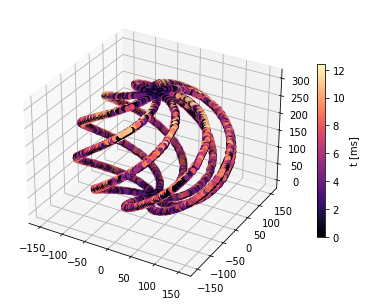

In [10]:
ax, sc = dwell_solver.show_solution()

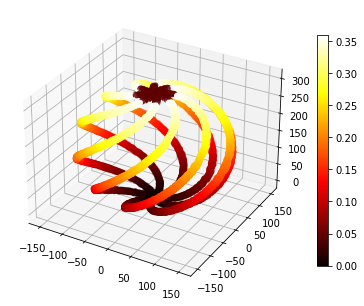

In [11]:
resistance = model.resistance
ax, sc = struct.plot_slices(c=np.concatenate(resistance), cmap='hot')
plt.colorbar(sc, shrink=0.8)

### Save the stream

In [5]:
save_path = 'stream_test'

strm = stream_builder.get_stream()
strm.write(save_path)
save_build(save_path, dwell_solver, stream_builder)

#### Load the stream

In [6]:
load_path = 'stream_test.pickle'
strm.from_file('stream_test.str')
dwell_solver, stream_builder = load_build(load_path)